# Fitting a Gaussian Process to USGS Bathymetry Data

In [7]:
# All imports here...

# Numpy and linear algebra libraries
import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.pyplot as plt
import progressbar
import imp
from multiprocessing import Process, Value, Array

import csv

import tensorly as tl
import itertools

import TensorToolbox.multilinalg as mla
import TensorToolbox as DT
from TensorToolbox.core import STT
import SpectralToolbox
from sklearn.externals.joblib import Parallel, delayed
from sklearn.model_selection import KFold

import gaussian_process as GP

Plotting data...


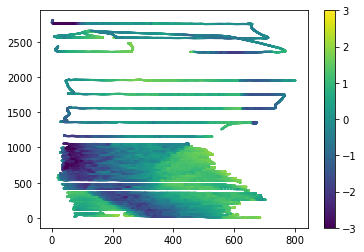

In [2]:
FILENAME = 'data/usgs_bath_data/capstone_data_sample.csv'
data=[]
meanHeight = 0

# Angle to rotate the river data by
ROT_ANGLE = 0.13 * np.pi

# Rotate to align river with axes
ROT_MATRIX = np.array([
        [np.cos(ROT_ANGLE), -np.sin(ROT_ANGLE),  0],
        [np.sin(ROT_ANGLE),  np.cos(ROT_ANGLE),  0],
        [0,                  0,                  1]
        ], dtype=float)

cdict = {
  'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
  'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
  'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
}

cm = matplotlib.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

def import_data():
    global data
    with open(FILENAME) as csvfile:
        filereader = csv.reader(csvfile, delimiter=',')
        header = True
        for row in filereader:
            if header:
                header = False
            else:
                data.append([float(row[1]), float(row[2]), float(row[4])])

    data = np.array(data, dtype=float)
    data = data.transpose()

def preprocess(data):
    '''
    Translate / rotate the data, normalize it so that it has mean 0.
    :param data:
    :return:
    '''
    global meanHeight
    data[0, :] -= min(data[0, :])
    data[1, :] -= min(data[1, :])
    meanHeight = np.mean(data[2, :])
    data[2, :] -= meanHeight

def plotData(data, colors):
    print("Plotting data...")
    plt.figure()
    plt.scatter(data[0, :], data[1, :], c = colors, s = 1, vmin=-3, vmax=3)
    plt.colorbar()
    # plt.show()
    # print("Plotting complete.")

import_data()
data = np.matmul(ROT_MATRIX, data)
preprocess(data)
plotData(data, data[2, :])
plt.show()

### Gaussian Process w/ simple subset-of-data approximation

In [153]:
imp.reload(GP)

# Build the Gaussian process (using the homemade GaussianProcess class)
sampleSize = 2000
gp = GP.GaussianProcess('RBF', [90], 0.3)
sample = np.random.permutation(data.transpose())[:sampleSize]

print("Building Gaussian Process...")
gp.build_sd(sample[:, 0:2], sample[:, 2:3])
print("Built Gaussian Process...")

Building Gaussian Process...
Itr: 91
Built Gaussian Process...


### Querying from the Gaussian Process

100% (5000 of 5000) |####################| Elapsed Time: 0:01:00 Time:  0:01:00

Plotting data...
Plotting data...


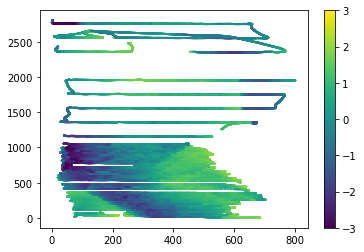

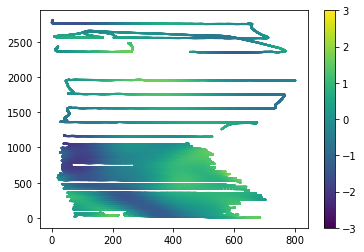

0.44198153182532773


In [156]:
# Query the GP; we can use multithreading to do this efficiently...
predMeans = Array('f', len(data.transpose()))

threads = []
numThreads = 22
threadWidth = 5000
dt = data.transpose()

def threadFunc(tid, predMeans):
    for i in progressbar.progressbar(range(threadWidth)):
        predMeans[tid * threadWidth + i] = process.query(dt[tid * threadWidth + i, 0:2])[0]

# For convenience, work exclusively with the first m points in the dataset
for i in range(numThreads):
    threads.append(Process(target=threadFunc, args=(i,predMeans)))
    threads[-1].start()
    
for t in threads:
    t.join()
    
plotData(data[:, 0:threadWidth * numThreads], data[2, 0:threadWidth * numThreads])
plotData(data[:, 0:threadWidth * numThreads], predMeans[0:threadWidth * numThreads])
plt.show()
    
# Get the mean-squared error

mse = np.sqrt((la.norm(data[2, 0:threadWidth * numThreads] - predMeans[0:threadWidth * numThreads]) ** 2) / (threadWidth * numThreads))
print(mse)

In [128]:
# Get the RMSE

mse = np.sqrt((la.norm(data[2, 0:threadWidth * numThreads] - predMeans[0:threadWidth * numThreads]) ** 2) / (threadWidth * numThreads))
print(mse)

0.28241967196644896


### Clustering the input data for induced input locations

In [124]:
imp.reload(GP)

centers = GP.lloydKMeans(data.transpose()[:, 0:2], 100, 25)

100% (25 of 25) |########################| Elapsed Time: 0:30:02 Time:  0:30:02

Plotting data...


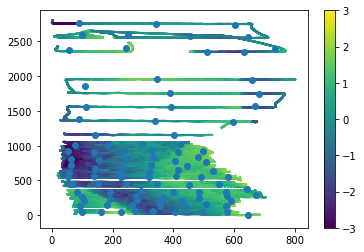

In [125]:
plotData(data, data[2, :])
plt.scatter(centers[:, 0], centers[:, 1])
plt.show()

In [155]:
# Training Gaussian Process on the clusters...

imp.reload(GP)

print("Training GP...")
process = GP.GaussianProcess('RBF', [140], 0.9)
process.build_ii(data.transpose()[:, 0:2], data.transpose()[:, 2], 100, None, Xbar=centers[:100])
print("GP Trained...")

Training GP...
GP Trained...


### Approximating the GP Using a Spectral Tensor Train Decomposition

In [166]:
# Use spectral tensor train to approximate the mean function

subdivs = 120
xRange = 800.0
yRange = 3000.0
grid = [np.arange(-1, xRange, (xRange + 1) / subdivs), np.arange(-1, yRange, (yRange + 1) / subdivs)]

approximation = STT(lambda X, params: gp.query(X)[0], grid, params=0, surrogateONOFF = True, surrogate_type='LinearInterpolation')

res = approximation.build()

In [ ]:
pt=np.array([500, 200])

print(approximation.__call__(pt))
print(gp.query(pt))

# Evaluate the Algorithms using Cross-Validation

In [150]:
imp.reload(GP)

# Currently using 10-fold cross-validation; hyperparameters trained on 500
# points selected randomly from the training set.
validationSize = 400
sampleSize = 2000    # Sample size for the subset-of-data approximation

def trainTest(tid, trainIdx, testIdx, rmse):
    try:
        # Not great to reuse the validation set for training... but doesn't make a difference here...
        train = data.transpose()[trainIdx]
        validation = np.random.permutation(train)[:validationSize]
        test = data.transpose()[testIdx]
        print("Datasets prepared...")
    
        gp = GP.GaussianProcess('RBF', [100], 0.8)
    
        # Learn the hyperparameters on the validation set
        print("Learning hyperparameters...")
        gp.learn_hyperparameters(validation[:, 0:2], validation[:, 2], 'II', centers=centers)
        print(gp.hp)
        print("Hyperparameters learned!")
    
        # Perform learning using the the remaining data
        gp.build_ii(train[:, 0:2], train[:, 2], 100, None, Xbar=centers)
        print("Gaussian process trained!")
    
        # Make predictions and evaluate the results here
        predMeans = np.zeros(len(test))
        for i in range(len(test)):
            predMeans[i] = gp.query(test[i, 0:2])[0]
    
        rmse[tid] = np.sqrt(la.norm(predMeans - test[:, 2]) ** 2 / len(test))
    except Exception as e:
        print(e)
        
n_splits=10
rmse = Array('f', n_splits)

threads = []
kf = KFold(n_splits=n_splits, shuffle=True, random_state=np.random.randint(100))

# Use multiprocessing to work on the 10 splits in parallel..
tid = 0
for a, b in kf.split(data.transpose()):
    trainTest(tid, a, b, rmse)
    # threads.append(Process(target=trainTest, args=(tid, a, b, rmse)))
    # threads[-1].start()
    tid += 1
    
# Wait for all threads to join up
for t in threads:
    t.join()
    
print("All complete...")

Datasets prepared...
Learning hyperparameters...
[156.98862531]
Hyperparameters learned!
Gaussian process trained!
Datasets prepared...
Learning hyperparameters...
[136.34692383]
Hyperparameters learned!
Gaussian process trained!
Datasets prepared...
Learning hyperparameters...
[144.42804771]
Hyperparameters learned!
Gaussian process trained!
Datasets prepared...
Learning hyperparameters...
[143.20493563]
Hyperparameters learned!
Gaussian process trained!
Datasets prepared...
Learning hyperparameters...
[144.20456601]
Hyperparameters learned!
Gaussian process trained!
Datasets prepared...
Learning hyperparameters...
[135.63055801]
Hyperparameters learned!
Gaussian process trained!
Datasets prepared...
Learning hyperparameters...
[147.41656113]
Hyperparameters learned!
Gaussian process trained!
Datasets prepared...
Learning hyperparameters...
[150.78586161]
Hyperparameters learned!
Gaussian process trained!
Datasets prepared...
Learning hyperparameters...
[140.60962677]
Hyperparameters 

In [122]:
# Analyze the results

print(errs_noise04)
print(np.mean(errs_noise04))
print(np.std(errs_noise04))

print(np.array(errs_noise03))
print(np.mean(errs_noise03))
print(np.std(errs_noise03))

[0.31677598 0.29900554 0.29836553 0.30090824 0.29168236 0.3337115
 0.30422395 0.29917276 0.2929467  0.3055585 ]
0.30423510670661924
0.01188014432380538
[0.25383839 0.2790828  0.26571447 0.28405991 0.26571703 0.28533527
 0.28184459 0.27456796 0.2617293  0.28226081]
0.2734150528907776
0.010375561571138163


In [151]:
print(np.mean(rmse))
print(np.std(rmse))

0.5550988435745239
0.00430586248735742


In [149]:
np.array(rmse)

array([0.46171823, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])